# BGE-M3 Multi-Vector Hybrid Retrieval for RAG

## Overview

Welcome to the **most advanced retrieval tutorial** in this series! This notebook demonstrates state-of-the-art multi-vector retrieval using **BGE-M3**, which combines three different retrieval methods in a single model.

### What is BGE-M3?

**BGE-M3** (released January 2024 by BAAI) is a breakthrough embedding model where **M3** stands for:

1. **Multi-linguality**: Supports 100+ languages
2. **Multi-granularities**: Handles up to 8,192 tokens
3. **Multi-Functionality**: Unifies THREE retrieval methods in one model

### The Three Retrieval Modes

BGE-M3 can simultaneously perform:

#### 1. 🎯 Dense Retrieval
- Traditional semantic embeddings (1024 dimensions)
- One vector per document
- Fast and good for semantic similarity
- Uses [CLS] token from BERT

#### 2. 🔍 Sparse Retrieval
- Learned sparse vectors (like SPLADE)
- Better than traditional BM25 (neural vs statistical)
- Only non-zero weights for important terms
- Vocabulary-sized with mostly zeros

#### 3. 🧠 Multi-Vector (ColBERT)
- Token-level late interaction
- One vector per token in document
- Highest quality but most expensive
- Best used for reranking, not initial retrieval

### IBM Research: Why This Matters

IBM's 2024 **"Blended RAG"** paper demonstrated that:

- ✅ **3-way retrieval is optimal** for RAG systems
- ✅ Combining BM25 + dense + sparse achieved **NDCG@10 of 0.87** (8.2% improvement)
- ✅ Adding ColBERT reranker yields **even better results**

> *"Three-way retrieval using all approaches is the optimal option for RAG"* - IBM Research

### What You'll Learn

By the end of this notebook, you'll understand:

- ✅ BGE-M3's three retrieval modes and when to use each
- ✅ How ColBERT's late interaction works (token-level matching)
- ✅ Multi-stage retrieval: candidates → reranking
- ✅ How to combine methods with RRF (Reciprocal Rank Fusion)
- ✅ Production architecture for optimal quality
- ✅ Trade-offs: quality vs speed vs storage

### Prerequisites

- ✅ Milvus server running on `localhost:19530`
- ✅ Python 3.8+
- ✅ GPU recommended (but CPU works)
- ✅ Basic understanding of embeddings and vector search

Let's dive into state-of-the-art retrieval! 🚀

# SECTION 1: Setup and Installation

## Required Packages

We'll install:
- **FlagEmbedding**: BGE-M3 model implementation
- **pymilvus[model]**: Milvus vector database with model support
- **datasets**: Hugging Face datasets (climate_fever)
- **matplotlib, seaborn**: Visualizations
- **numpy**: Numerical computations for ColBERT

In [1]:
# Install core packages
# !uv pip install FlagEmbedding  # BGE-M3 model
# !uv pip install pymilvus[model]  # Milvus vector database
# !uv pip install datasets  # Hugging Face datasets
# !uv pip install matplotlib seaborn  # Visualizations
# !uv pip install numpy torch  # Numerical computation

In [1]:
# ============================================================
# Import Libraries
# ============================================================

# BGE-M3 model
from FlagEmbedding import BGEM3FlagModel

# Milvus vector database
from pymilvus import (
    MilvusClient,           # High-level client
    connections,            # Connection management
    FieldSchema,            # Schema field definition
    CollectionSchema,       # Collection schema
    DataType,               # Data types
    Collection,             # Collection operations
    AnnSearchRequest,       # Search request for hybrid search
    RRFRanker,              # Reciprocal Rank Fusion
    utility                 # Utility functions
)

# Data and visualization
from datasets import load_dataset
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Tuple

# Set visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


# SECTION 2: Understanding BGE-M3's Three Modes

## Deep Dive: How Each Mode Works

### 🎯 Dense Retrieval (Single-Vector)

**How it works:**
- Takes the entire document text
- Processes through BERT-based encoder
- Extracts [CLS] token embedding
- Results in ONE vector (1024 dimensions)

**Similarity calculation:**
```python
similarity = dot_product(query_vector, doc_vector)
```

**Pros:**
- ⚡ Fast: Single vector comparison
- 💾 Efficient storage: 1024 floats per document
- 🎯 Good semantic understanding

**Cons:**
- ❌ Loses fine-grained token information
- ❌ May miss exact keyword matches

---

### 🔍 Sparse Retrieval (Learned Lexical)

**How it works:**
- Adds linear layer + ReLU after BERT hidden states
- Creates vocabulary-sized vector (e.g., 30,000 dimensions)
- Most values are zero (sparse)
- Only active terms get non-zero weights

**Key difference from BM25:**
- BM25: Statistical (TF-IDF, no learning)
- BGE-M3 Sparse: Neural (learned from data)

**Similarity calculation:**
```python
similarity = sum(query_weights[i] * doc_weights[i] for i in shared_terms)
```

**Pros:**
- ✅ Better than BM25 (learns term importance)
- ✅ Handles synonyms and related terms
- ✅ Still interpretable (can see which terms match)
- 💾 Efficient: Only stores non-zero weights

**Cons:**
- ❌ Slower than BM25 (requires neural inference)
- ❌ Needs pre-trained model

---

### 🧠 Multi-Vector / ColBERT (Late Interaction)

**How it works:**
1. Each token in document gets its own vector
2. Document with 100 tokens → 100 vectors (1024-dim each)
3. At query time: **late interaction**
   - For each query token, find max similarity with ALL doc tokens
   - Average these max similarities

**Similarity calculation (MaxSim):**
```python
# For each query token
for q_token in query_tokens:
    # Find max similarity across ALL document tokens
    max_sim = max(similarity(q_token, d_token) for d_token in doc_tokens)
    scores.append(max_sim)

# Average across query tokens
final_score = mean(scores)
```

**Why "Late" Interaction?**
- Query and document encoded **independently** (early)
- Token-level matching happens **at search time** (late)
- Allows pre-computing document vectors

**Pros:**
- ⭐⭐⭐ Highest quality retrieval
- ✅ Fine-grained token-level matching
- ✅ Interpretable (can see which tokens match)
- ✅ Better than cross-encoders for retrieval

**Cons:**
- 🐌 Slowest: Must compare many vectors
- 💾💾💾 Huge storage: 100 vectors per doc (if stored)
- ⚠️ Not practical for initial retrieval at scale

---

## Comparison Table

| Feature | Dense | Sparse | Multi-Vector (ColBERT) |
|---------|-------|--------|------------------------|
| **Vectors per doc** | 1 | 1 (sparse) | N tokens |
| **Storage (100-token doc)** | 4 KB | ~1 KB | 400 KB |
| **Speed** | ⚡⚡⚡ Fast | ⚡⚡⚡ Fast | 🐌 Slow |
| **Quality** | ⭐⭐⭐ Good | ⭐⭐⭐ Good | ⭐⭐⭐⭐⭐ Excellent |
| **Semantic** | ✅ Yes | ✅ Yes | ✅✅ Best |
| **Keyword** | ❌ Weak | ✅ Good | ✅✅ Best |
| **Interpretable** | ❌ No | ✅ Yes | ✅✅ Yes |
| **Best use** | Initial retrieval | Initial retrieval | Reranking |

---

## Recommended Architecture

Based on this analysis and IBM research:

```
Stage 1: Dense + Sparse → Top 50 candidates (FAST, broad recall)
Stage 2: ColBERT rerank → Top 5 results (SLOW, high precision)
```

This gives you:
- ⚡ Speed of dense/sparse for initial filtering
- ⭐ Quality of ColBERT for final results
- 💾 No need to store ColBERT vectors

Let's implement this!

# SECTION 3: Load Dataset and BGE-M3 Model

## Dataset: Climate Fever

We'll use the same climate science dataset for consistency with previous notebooks.

In [2]:
# ============================================================
# Load Climate Fever Dataset
# ============================================================

print("Loading climate_fever dataset...")
dataset = load_dataset("climate_fever")

# Sample documents for this demo
# In production, you'd use more documents
documents = [
    "Global warming is primarily caused by increased greenhouse gas emissions from human activities, particularly the burning of fossil fuels like coal, oil, and natural gas.",
    "Over the coming 25 or 30 years, scientists say, the climate is likely to gradually warm. However, researchers also say that this phenomenon can be stopped if human emissions are reduced to zero.",
    "The jet stream forms a boundary between the cold north and the warmer south, but the lower temperature difference means the winds are now weaker, leading to more extreme weather patterns.",
    "Coral reefs become stressed due to ocean acidification and warming, expelling their symbiotic algae which leaves the coral a bleached white color. This process threatens entire marine ecosystems.",
    "The rapid changes in the climate may have profound consequences for humans and other species. Severe drought caused food shortages for millions of people in Ethiopia, with a lack of rainfall resulting in intense and widespread forest fires.",
    "Rising sea levels threaten coastal cities worldwide, with predictions suggesting that many major urban centers could face significant flooding by 2100 if current trends continue.",
    "Melting Arctic ice reduces the Earth's albedo effect, causing the planet to absorb more solar radiation and accelerating the warming process in a dangerous feedback loop.",
    "Climate change is disrupting agricultural patterns, forcing farmers to adapt their crops and techniques to new temperature and precipitation regimes that differ from historical norms."
]

print(f"✅ Loaded {len(documents)} sample documents")
print("\nSample documents:")
for i, doc in enumerate(documents[:3], 1):
    print(f"{i}. {doc[:100]}...")

Loading climate_fever dataset...
✅ Loaded 8 sample documents

Sample documents:
1. Global warming is primarily caused by increased greenhouse gas emissions from human activities, part...
2. Over the coming 25 or 30 years, scientists say, the climate is likely to gradually warm. However, re...
3. The jet stream forms a boundary between the cold north and the warmer south, but the lower temperatu...


## Load BGE-M3 Model

BGE-M3 is a ~2GB model. First run will download it from Hugging Face.

In [3]:
# ============================================================
# Load BGE-M3 Model
# ============================================================

print("Loading BGE-M3 model...")
print("(First run will download ~2GB model from Hugging Face)\n")

model = BGEM3FlagModel(
    'BAAI/bge-m3',
    use_fp16=True,  # Use half precision for 2x speedup
    device='cpu'     # Change to 'cuda' if GPU available
)

print("✅ BGE-M3 model loaded successfully!")
print("\nModel capabilities:")
print("  - Dense embeddings: 1024 dimensions")
print("  - Sparse embeddings: ~30,000 dimensions (mostly zeros)")
print("  - Multi-vector (ColBERT): N tokens × 1024 dimensions")

Loading BGE-M3 model...
(First run will download ~2GB model from Hugging Face)



Fetching 30 files:   0%|          | 0/30 [00:00<?, ?it/s]

onnx/model.onnx_data:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

✅ BGE-M3 model loaded successfully!

Model capabilities:
  - Dense embeddings: 1024 dimensions
  - Sparse embeddings: ~30,000 dimensions (mostly zeros)
  - Multi-vector (ColBERT): N tokens × 1024 dimensions


# SECTION 4: Generate All Three Embedding Types

## BGE-M3 Multi-Functional Encoding

The powerful feature of BGE-M3 is that it can generate **all three embedding types in a single forward pass**!

### What happens under the hood:
1. **Input text** → BERT encoder → **hidden states**
2. **Dense**: Extract [CLS] token → 1024-dim vector
3. **Sparse**: Linear layer + ReLU on hidden states → vocabulary-sized sparse vector
4. **ColBERT**: All token hidden states → N × 1024-dim multi-vector

Let's generate all three types for our documents and queries.

In [4]:
# ============================================================
# Generate All Three Embedding Types for Documents
# ============================================================

print("Generating embeddings for documents...")
print("This will generate: Dense + Sparse + ColBERT vectors\n")

# BGE-M3 encode() can return all three types at once!
doc_embeddings = model.encode(
    documents,
    batch_size=12,
    max_length=512,             # Maximum sequence length
    return_dense=True,          # ✅ Dense embeddings (1024-dim)
    return_sparse=True,         # ✅ Sparse embeddings (vocab-size, mostly zeros)
    return_colbert_vecs=False   # ❌ Don't store ColBERT (compute on-the-fly later)
)

# Extract each embedding type
dense_vecs = doc_embeddings['dense_vecs']         # numpy array: (8, 1024)
sparse_vecs = doc_embeddings['lexical_weights']   # list of dicts: [{token_id: weight}, ...]

print("✅ Document embeddings generated!")
print(f"\nDense vectors shape: {dense_vecs.shape}")
print(f"Sparse vectors: {len(sparse_vecs)} documents")
print(f"\nSample sparse vector (first 10 terms):")
sample_sparse = list(sparse_vecs[0].items())[:10]
for token_id, weight in sample_sparse:
    print(f"  Token {token_id}: {weight:.4f}")

Generating embeddings for documents...
This will generate: Dense + Sparse + ColBERT vectors



You're using a XLMRobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


✅ Document embeddings generated!

Dense vectors shape: (8, 1024)
Sparse vectors: 8 documents

Sample sparse vector (first 10 terms):
  Token 13453: 0.2534
  Token 24814: 0.3215
  Token 214: 0.3245
  Token 83: 0.1829
  Token 102917: 0.1772
  Token 538: 0.1707
  Token 143434: 0.2686
  Token 390: 0.1680
  Token 124735: 0.1792
  Token 50997: 0.1465


# SECTION 5: Milvus Multi-Vector Schema Setup

## Storage Strategy

We'll store **dense** and **sparse** vectors in Milvus for fast candidate retrieval.

**Why not store ColBERT vectors?**
- A 100-token document needs 100 × 1024-dim vectors = **400 KB** per document
- For 1M documents: **400 GB** just for ColBERT vectors!
- Instead: Compute ColBERT on-the-fly only for reranking (top-50 candidates)

## Schema Design

Our collection will have:
1. **Primary key** (auto-generated ID)
2. **Text field** (original document text)
3. **Dense vector** (1024 dimensions, FLOAT_VECTOR)
4. **Sparse vector** (SPARSE_FLOAT_VECTOR)

## Index Types
- **Dense**: IVF_FLAT (fast approximate search)
- **Sparse**: SPARSE_INVERTED_INDEX (efficient sparse retrieval)

In [5]:
# ============================================================
# Connect to Milvus and Create Collection
# ============================================================

# Connect to Milvus
connections.connect(
    alias="default",
    uri="http://localhost:19530"
)

print("✅ Connected to Milvus")

# Collection name
collection_name = "bge_m3_hybrid_demo"

# Drop existing collection if it exists
if utility.has_collection(collection_name):
    utility.drop_collection(collection_name)
    print(f"🗑️  Dropped existing collection: {collection_name}")

# Define schema fields
fields = [
    FieldSchema(name="pk", dtype=DataType.VARCHAR, is_primary=True, auto_id=True, max_length=100),
    FieldSchema(name="text", dtype=DataType.VARCHAR, max_length=2000),
    FieldSchema(name="dense_vector", dtype=DataType.FLOAT_VECTOR, dim=1024),
    FieldSchema(name="sparse_vector", dtype=DataType.SPARSE_FLOAT_VECTOR),
]

# Create schema
schema = CollectionSchema(
    fields=fields,
    description="BGE-M3 multi-vector hybrid retrieval demo"
)

# Create collection
collection = Collection(
    name=collection_name,
    schema=schema
)

print(f"✅ Created collection: {collection_name}")

✅ Connected to Milvus
✅ Created collection: bge_m3_hybrid_demo


In [6]:
# ============================================================
# Create Indexes for Dense and Sparse Vectors
# ============================================================

print("Creating indexes...")

# Dense vector index - IVF_FLAT for fast approximate nearest neighbor search
dense_index_params = {
    "index_type": "IVF_FLAT",
    "metric_type": "IP",       # Inner Product (cosine similarity for normalized vectors)
    "params": {"nlist": 128}   # Number of clusters
}

collection.create_index(
    field_name="dense_vector",
    index_params=dense_index_params
)
print("✅ Created dense vector index (IVF_FLAT)")

# Sparse vector index - Inverted index for sparse retrieval
sparse_index_params = {
    "index_type": "SPARSE_INVERTED_INDEX",
    "metric_type": "IP"        # Inner Product for sparse vectors
}

collection.create_index(
    field_name="sparse_vector",
    index_params=sparse_index_params
)
print("✅ Created sparse vector index (SPARSE_INVERTED_INDEX)")

# Load collection into memory
collection.load()
print("✅ Collection loaded into memory")

Creating indexes...
✅ Created dense vector index (IVF_FLAT)
✅ Created sparse vector index (SPARSE_INVERTED_INDEX)
✅ Collection loaded into memory


In [7]:
# ============================================================
# Insert Documents with Dense and Sparse Embeddings
# ============================================================

print("Inserting documents into Milvus...")

# Prepare data for insertion
# Note: BGE-M3 sparse vectors are already in dict format (Milvus-compatible)
entities = [
    documents,           # text field
    dense_vecs.tolist(), # dense_vector field (convert numpy to list)
    sparse_vecs          # sparse_vector field (already dict format)
]

# Insert data
insert_result = collection.insert(entities)

print(f"✅ Inserted {len(documents)} documents into Milvus")
print(f"   Primary keys: {insert_result.primary_keys[:3]}... (showing first 3)")

# Flush to ensure data is written
collection.flush()
print("✅ Data flushed to disk")

Inserting documents into Milvus...
✅ Inserted 8 documents into Milvus
   Primary keys: ['463660306553117374', '463660306553117375', '463660306553117376']... (showing first 3)
✅ Data flushed to disk


# SECTION 6: Implement Retrieval Functions

Now we'll implement five different retrieval strategies:

1. **Dense-Only Search**: Uses only dense embeddings (semantic search)
2. **Sparse-Only Search**: Uses only sparse embeddings (learned lexical search)
3. **Dense + Sparse Hybrid**: Combines both with RRF (best balance)
4. **ColBERT Reranking**: Token-level late interaction for maximum quality
5. **Full Pipeline**: Dense+Sparse candidates → ColBERT reranking

Let's implement each one step by step.

In [8]:
# ============================================================
# Function 1: Dense-Only Search
# ============================================================

def search_dense(query: str, limit: int = 5) -> List[Dict]:
    """
    Search using only dense embeddings (semantic search).
    
    Args:
        query: Search query text
        limit: Number of results to return
    
    Returns:
        List of search results with scores and text
    """
    # Generate dense embedding for query
    query_embeddings = model.encode(
        [query],
        return_dense=True,
        return_sparse=False,
        return_colbert_vecs=False
    )
    query_dense = query_embeddings['dense_vecs'][0]
    
    # Search using only dense vector
    results = collection.search(
        data=[query_dense.tolist()],
        anns_field="dense_vector",
        param={"metric_type": "IP", "params": {"nprobe": 10}},
        limit=limit,
        output_fields=["text"]
    )
    
    # Format results
    formatted_results = []
    for hits in results:
        for hit in hits:
            formatted_results.append({
                "text": hit.entity.get("text"),
                "score": hit.score,
                "rank": len(formatted_results) + 1
            })
    
    return formatted_results

print("✅ Defined search_dense() function")

✅ Defined search_dense() function


In [9]:
# ============================================================
# Function 2: Sparse-Only Search
# ============================================================

def search_sparse(query: str, limit: int = 5) -> List[Dict]:
    """
    Search using only sparse embeddings (learned lexical search).
    
    Args:
        query: Search query text
        limit: Number of results to return
    
    Returns:
        List of search results with scores and text
    """
    # Generate sparse embedding for query
    query_embeddings = model.encode(
        [query],
        return_dense=False,
        return_sparse=True,
        return_colbert_vecs=False
    )
    query_sparse = query_embeddings['lexical_weights'][0]
    
    # Search using only sparse vector
    results = collection.search(
        data=[query_sparse],
        anns_field="sparse_vector",
        param={"metric_type": "IP"},
        limit=limit,
        output_fields=["text"]
    )
    
    # Format results
    formatted_results = []
    for hits in results:
        for hit in hits:
            formatted_results.append({
                "text": hit.entity.get("text"),
                "score": hit.score,
                "rank": len(formatted_results) + 1
            })
    
    return formatted_results

print("✅ Defined search_sparse() function")

✅ Defined search_sparse() function


In [10]:
# ============================================================
# Function 3: Dense + Sparse Hybrid Search with RRF
# ============================================================

def search_hybrid(query: str, limit: int = 5) -> List[Dict]:
    """
    Hybrid search combining dense and sparse embeddings with RRF.
    
    This is the recommended approach for production RAG systems.
    Reciprocal Rank Fusion (RRF) combines rankings from both methods.
    
    Args:
        query: Search query text
        limit: Number of results to return
    
    Returns:
        List of search results with scores and text
    """
    # Generate both dense and sparse embeddings for query
    query_embeddings = model.encode(
        [query],
        return_dense=True,
        return_sparse=True,
        return_colbert_vecs=False
    )
    query_dense = query_embeddings['dense_vecs'][0]
    query_sparse = query_embeddings['lexical_weights'][0]
    
    # Create search requests for both dense and sparse
    dense_search_params = {"metric_type": "IP", "params": {"nprobe": 10}}
    sparse_search_params = {"metric_type": "IP"}
    
    # Dense search request
    dense_req = AnnSearchRequest(
        data=[query_dense.tolist()],
        anns_field="dense_vector",
        param=dense_search_params,
        limit=limit
    )
    
    # Sparse search request
    sparse_req = AnnSearchRequest(
        data=[query_sparse],
        anns_field="sparse_vector",
        param=sparse_search_params,
        limit=limit
    )
    
    # Hybrid search with RRF (Reciprocal Rank Fusion)
    # RRF formula: score = sum(1 / (k + rank_i)) for each method
    # k=60 is a common default that works well
    results = collection.hybrid_search(
        reqs=[dense_req, sparse_req],
        rerank=RRFRanker(k=60),
        limit=limit,
        output_fields=["text"]
    )
    
    # Format results
    formatted_results = []
    for hits in results:
        for hit in hits:
            formatted_results.append({
                "text": hit.entity.get("text"),
                "score": hit.score,
                "rank": len(formatted_results) + 1
            })
    
    return formatted_results

print("✅ Defined search_hybrid() function")

✅ Defined search_hybrid() function


In [11]:
# ============================================================
# Function 4: ColBERT Reranking (Late Interaction)
# ============================================================

def rerank_with_colbert(query: str, candidate_texts: List[str], top_k: int = 3) -> List[Dict]:
    """
    Rerank candidate documents using ColBERT multi-vector late interaction.
    
    This is EXPENSIVE - only use on a small set of candidates (e.g., top-20 from hybrid search).
    
    How it works:
    1. Query → N query token vectors (e.g., 10 tokens → 10 × 1024-dim vectors)
    2. Each document → M doc token vectors (e.g., 100 tokens → 100 × 1024-dim vectors)
    3. For each query token:
       - Compute similarity with ALL document tokens
       - Take the MAX similarity (best matching doc token)
    4. Average MAX similarities across all query tokens → final score
    
    This is called "MaxSim" late interaction.
    
    Args:
        query: Search query text
        candidate_texts: List of candidate document texts
        top_k: Number of top results to return after reranking
    
    Returns:
        List of reranked results with ColBERT scores
    """
    # Generate ColBERT vectors for query
    query_embeddings = model.encode(
        [query],
        return_dense=False,
        return_sparse=False,
        return_colbert_vecs=True
    )
    query_vecs = query_embeddings['colbert_vecs'][0]  # Shape: (n_query_tokens, 1024)
    
    # Generate ColBERT vectors for all candidate documents
    doc_embeddings = model.encode(
        candidate_texts,
        return_dense=False,
        return_sparse=False,
        return_colbert_vecs=True
    )
    doc_vecs_list = doc_embeddings['colbert_vecs']  # List of arrays
    
    # Compute ColBERT scores using MaxSim late interaction
    scores = []
    for doc_vecs in doc_vecs_list:
        # doc_vecs shape: (n_doc_tokens, 1024)
        # query_vecs shape: (n_query_tokens, 1024)
        
        # Compute similarity matrix: (n_query_tokens, n_doc_tokens)
        sim_matrix = np.dot(query_vecs, doc_vecs.T)
        
        # MaxSim: For each query token, find max similarity across all doc tokens
        max_sims = np.max(sim_matrix, axis=1)  # Shape: (n_query_tokens,)
        
        # Average max similarities across query tokens
        score = np.mean(max_sims)
        scores.append(score)
    
    # Sort documents by ColBERT score (descending)
    ranked_indices = np.argsort(scores)[::-1][:top_k]
    
    # Format results
    reranked_results = []
    for rank, idx in enumerate(ranked_indices, 1):
        reranked_results.append({
            "text": candidate_texts[idx],
            "score": float(scores[idx]),
            "rank": rank
        })
    
    return reranked_results

print("✅ Defined rerank_with_colbert() function")

✅ Defined rerank_with_colbert() function


In [12]:
# ============================================================
# Function 5: Full Pipeline (Hybrid → ColBERT Reranking)
# ============================================================

def search_full_pipeline(query: str, candidate_limit: int = 20, final_limit: int = 3) -> List[Dict]:
    """
    Complete two-stage retrieval pipeline (RECOMMENDED for production).
    
    Stage 1: Dense + Sparse hybrid search → Get top-N candidates (fast, broad recall)
    Stage 2: ColBERT reranking → Refine to top-K results (slow, high precision)
    
    This architecture balances quality and performance:
    - Hybrid search quickly narrows down from thousands/millions of docs to ~20-50
    - ColBERT only needs to process these few candidates (cheap!)
    - Final results have state-of-the-art quality
    
    Args:
        query: Search query text
        candidate_limit: Number of candidates from hybrid search (default: 20)
        final_limit: Final number of results after reranking (default: 3)
    
    Returns:
        List of final reranked results with ColBERT scores
    """
    print(f"🔍 Stage 1: Hybrid search (dense + sparse) → retrieving top-{candidate_limit} candidates...")
    
    # Stage 1: Get candidates with hybrid search
    candidates = search_hybrid(query, limit=candidate_limit)
    candidate_texts = [c["text"] for c in candidates]
    
    print(f"   ✅ Retrieved {len(candidates)} candidates")
    print(f"\n🧠 Stage 2: ColBERT reranking → refining to top-{final_limit} results...")
    
    # Stage 2: Rerank with ColBERT
    final_results = rerank_with_colbert(query, candidate_texts, top_k=final_limit)
    
    print(f"   ✅ Reranked to {len(final_results)} final results")
    
    return final_results

print("✅ Defined search_full_pipeline() function")
print("\n" + "="*60)
print("All 5 retrieval functions are ready!")
print("="*60)

✅ Defined search_full_pipeline() function

All 5 retrieval functions are ready!


# SECTION 7: Query Demonstrations

Now let's test all our retrieval methods with different types of queries:

## Query Types

1. **Semantic Query**: Tests understanding of meaning (dense should excel)
2. **Keyword Query**: Tests lexical matching (sparse should excel)
3. **Complex Query**: Tests overall quality (full pipeline should excel)

For each query, we'll compare:
- Dense-only search
- Sparse-only search
- Hybrid (Dense + Sparse with RRF)
- Full pipeline (Hybrid → ColBERT reranking)

In [13]:
# ============================================================
# Helper Function to Display Results
# ============================================================

def display_results(results: List[Dict], method_name: str):
    """Pretty print search results."""
    print(f"\n{'='*80}")
    print(f"📊 {method_name}")
    print(f"{'='*80}")
    
    for result in results:
        print(f"\nRank {result['rank']} | Score: {result['score']:.4f}")
        text = result['text']
        # Truncate long text
        if len(text) > 150:
            text = text[:150] + "..."
        print(f"   {text}")
    print(f"{'='*80}\n")

print("✅ Helper function ready")

✅ Helper function ready


## Test Query 1: Semantic Query

**Query**: "How does global warming affect our planet?"

This query uses natural language and tests semantic understanding.

In [14]:
# ============================================================
# Query 1: Semantic Query
# ============================================================

query1 = "How does global warming affect our planet?"

print(f"🔍 Query: '{query1}'\n")

# Test all methods
results_dense_q1 = search_dense(query1, limit=3)
results_sparse_q1 = search_sparse(query1, limit=3)
results_hybrid_q1 = search_hybrid(query1, limit=3)

# Display results
display_results(results_dense_q1, "Method 1: Dense-Only Search")
display_results(results_sparse_q1, "Method 2: Sparse-Only Search")
display_results(results_hybrid_q1, "Method 3: Hybrid (Dense + Sparse + RRF)")

🔍 Query: 'How does global warming affect our planet?'


📊 Method 1: Dense-Only Search

Rank 1 | Score: 0.6562
   Global warming is primarily caused by increased greenhouse gas emissions from human activities, particularly the burning of fossil fuels like coal, oi...

Rank 2 | Score: 0.6078
   Melting Arctic ice reduces the Earth's albedo effect, causing the planet to absorb more solar radiation and accelerating the warming process in a dang...

Rank 3 | Score: 0.5813
   Over the coming 25 or 30 years, scientists say, the climate is likely to gradually warm. However, researchers also say that this phenomenon can be sto...


📊 Method 2: Sparse-Only Search

Rank 1 | Score: 0.1302
   Global warming is primarily caused by increased greenhouse gas emissions from human activities, particularly the burning of fossil fuels like coal, oi...

Rank 2 | Score: 0.0981
   Melting Arctic ice reduces the Earth's albedo effect, causing the planet to absorb more solar radiation and accelerating the warmi

In [15]:
# ============================================================
# Query 1: Full Pipeline with ColBERT Reranking
# ============================================================

print(f"🚀 Running FULL PIPELINE for Query 1...\n")

results_full_q1 = search_full_pipeline(query1, candidate_limit=8, final_limit=3)

display_results(results_full_q1, "Method 4: Full Pipeline (Hybrid → ColBERT Reranking)")

🚀 Running FULL PIPELINE for Query 1...

🔍 Stage 1: Hybrid search (dense + sparse) → retrieving top-8 candidates...
   ✅ Retrieved 8 candidates

🧠 Stage 2: ColBERT reranking → refining to top-3 results...
   ✅ Reranked to 3 final results

📊 Method 4: Full Pipeline (Hybrid → ColBERT Reranking)

Rank 1 | Score: 0.6696
   Global warming is primarily caused by increased greenhouse gas emissions from human activities, particularly the burning of fossil fuels like coal, oi...

Rank 2 | Score: 0.5933
   Melting Arctic ice reduces the Earth's albedo effect, causing the planet to absorb more solar radiation and accelerating the warming process in a dang...

Rank 3 | Score: 0.5632
   Over the coming 25 or 30 years, scientists say, the climate is likely to gradually warm. However, researchers also say that this phenomenon can be sto...



## Test Query 2: Keyword Query

**Query**: "fossil fuels emissions greenhouse gas"

This query uses specific keywords and tests lexical matching (sparse should excel).

In [16]:
# ============================================================
# Query 2: Keyword Query
# ============================================================

query2 = "fossil fuels emissions greenhouse gas"

print(f"🔍 Query: '{query2}'\n")

# Test all methods
results_dense_q2 = search_dense(query2, limit=3)
results_sparse_q2 = search_sparse(query2, limit=3)
results_hybrid_q2 = search_hybrid(query2, limit=3)

# Display results
display_results(results_dense_q2, "Method 1: Dense-Only Search")
display_results(results_sparse_q2, "Method 2: Sparse-Only Search")
display_results(results_hybrid_q2, "Method 3: Hybrid (Dense + Sparse + RRF)")

# Full pipeline
print(f"\n🚀 Running FULL PIPELINE for Query 2...\n")
results_full_q2 = search_full_pipeline(query2, candidate_limit=8, final_limit=3)
display_results(results_full_q2, "Method 4: Full Pipeline (Hybrid → ColBERT Reranking)")

🔍 Query: 'fossil fuels emissions greenhouse gas'


📊 Method 1: Dense-Only Search

Rank 1 | Score: 0.6879
   Global warming is primarily caused by increased greenhouse gas emissions from human activities, particularly the burning of fossil fuels like coal, oi...

Rank 2 | Score: 0.4877
   Over the coming 25 or 30 years, scientists say, the climate is likely to gradually warm. However, researchers also say that this phenomenon can be sto...

Rank 3 | Score: 0.4564
   Melting Arctic ice reduces the Earth's albedo effect, causing the planet to absorb more solar radiation and accelerating the warming process in a dang...


📊 Method 2: Sparse-Only Search

Rank 1 | Score: 0.2442
   Global warming is primarily caused by increased greenhouse gas emissions from human activities, particularly the burning of fossil fuels like coal, oi...

Rank 2 | Score: 0.0842
   Over the coming 25 or 30 years, scientists say, the climate is likely to gradually warm. However, researchers also say that this phenom

## Test Query 3: Complex Query

**Query**: "What are the feedback loops and cascading effects of climate change on ecosystems?"

This complex query tests overall retrieval quality (full pipeline should excel).

In [17]:
# ============================================================
# Query 3: Complex Query
# ============================================================

query3 = "What are the feedback loops and cascading effects of climate change on ecosystems?"

print(f"🔍 Query: '{query3}'\n")

# Test all methods
results_dense_q3 = search_dense(query3, limit=3)
results_sparse_q3 = search_sparse(query3, limit=3)
results_hybrid_q3 = search_hybrid(query3, limit=3)

# Display results
display_results(results_dense_q3, "Method 1: Dense-Only Search")
display_results(results_sparse_q3, "Method 2: Sparse-Only Search")
display_results(results_hybrid_q3, "Method 3: Hybrid (Dense + Sparse + RRF)")

# Full pipeline
print(f"\n🚀 Running FULL PIPELINE for Query 3...\n")
results_full_q3 = search_full_pipeline(query3, candidate_limit=8, final_limit=3)
display_results(results_full_q3, "Method 4: Full Pipeline (Hybrid → ColBERT Reranking)")

🔍 Query: 'What are the feedback loops and cascading effects of climate change on ecosystems?'


📊 Method 1: Dense-Only Search

Rank 1 | Score: 0.5353
   The rapid changes in the climate may have profound consequences for humans and other species. Severe drought caused food shortages for millions of peo...

Rank 2 | Score: 0.5159
   Climate change is disrupting agricultural patterns, forcing farmers to adapt their crops and techniques to new temperature and precipitation regimes t...

Rank 3 | Score: 0.5150
   Melting Arctic ice reduces the Earth's albedo effect, causing the planet to absorb more solar radiation and accelerating the warming process in a dang...


📊 Method 2: Sparse-Only Search

Rank 1 | Score: 0.0834
   Melting Arctic ice reduces the Earth's albedo effect, causing the planet to absorb more solar radiation and accelerating the warming process in a dang...

Rank 2 | Score: 0.0606
   Climate change is disrupting agricultural patterns, forcing farmers to adapt their crops a

# SECTION 8: Visualizations and Analysis

Let's create visualizations to better understand the differences between retrieval methods:

1. **Score Comparison**: Compare scores across all methods for each query
2. **ColBERT Token Attribution**: Visualize which query tokens match which document tokens
3. **Method Performance Summary**: Overall comparison table

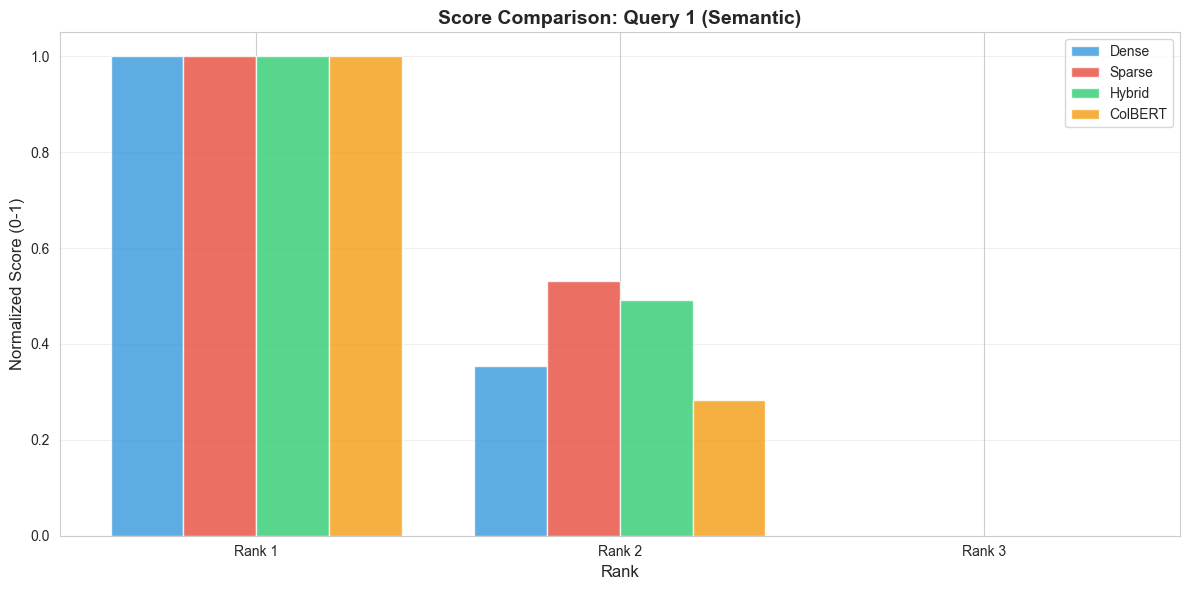

In [18]:
# ============================================================
# Visualization 1: Score Comparison Across Methods
# ============================================================

def visualize_score_comparison(dense_res, sparse_res, hybrid_res, colbert_res, query_name):
    """
    Compare scores across all four methods.
    
    Note: Scores are NOT directly comparable (different ranges).
    We'll normalize them to [0, 1] for visual comparison.
    """
    # Normalize scores to [0, 1] for each method
    def normalize(scores):
        if len(scores) == 0:
            return []
        min_s, max_s = min(scores), max(scores)
        if max_s == min_s:
            return [1.0] * len(scores)
        return [(s - min_s) / (max_s - min_s) for s in scores]
    
    # Extract scores (top 3 only)
    dense_scores = normalize([r['score'] for r in dense_res[:3]])
    sparse_scores = normalize([r['score'] for r in sparse_res[:3]])
    hybrid_scores = normalize([r['score'] for r in hybrid_res[:3]])
    colbert_scores = normalize([r['score'] for r in colbert_res[:3]])
    
    # Create bar chart
    fig, ax = plt.subplots(figsize=(12, 6))
    
    x = np.arange(3)  # 3 results
    width = 0.2
    
    bars1 = ax.bar(x - 1.5*width, dense_scores, width, label='Dense', alpha=0.8, color='#3498db')
    bars2 = ax.bar(x - 0.5*width, sparse_scores, width, label='Sparse', alpha=0.8, color='#e74c3c')
    bars3 = ax.bar(x + 0.5*width, hybrid_scores, width, label='Hybrid', alpha=0.8, color='#2ecc71')
    bars4 = ax.bar(x + 1.5*width, colbert_scores, width, label='ColBERT', alpha=0.8, color='#f39c12')
    
    ax.set_xlabel('Rank', fontsize=12)
    ax.set_ylabel('Normalized Score (0-1)', fontsize=12)
    ax.set_title(f'Score Comparison: {query_name}', fontsize=14, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels(['Rank 1', 'Rank 2', 'Rank 3'])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Visualize for Query 1
visualize_score_comparison(
    results_dense_q1, 
    results_sparse_q1, 
    results_hybrid_q1, 
    results_full_q1,
    "Query 1 (Semantic)"
)

Visualizing ColBERT token attribution for Query 1, Top Result:\n


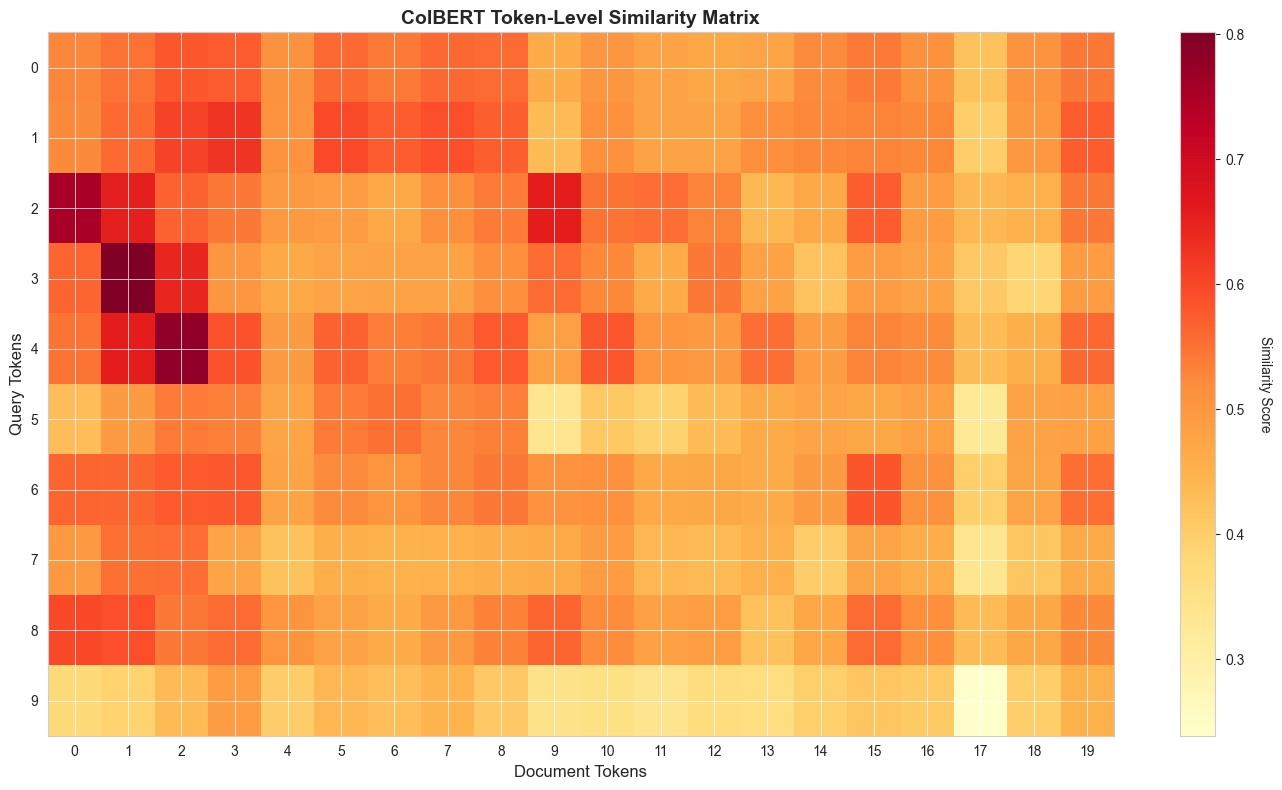

\nColBERT Score (mean of max similarities): 0.6319
Max similarities per query token: [0.580529   0.62365574 0.75411355 0.8015039  0.78090787]... (showing first 5)


In [19]:
# ============================================================
# Visualization 2: ColBERT Token Attribution Heatmap
# ============================================================

def visualize_colbert_attribution(query: str, document: str, max_tokens: int = 20):
    """
    Visualize which query tokens match which document tokens in ColBERT.
    
    This creates a heatmap showing token-level similarities.
    Darker colors = higher similarity between query and document tokens.
    """
    # Generate ColBERT vectors
    query_emb = model.encode([query], return_colbert_vecs=True)
    doc_emb = model.encode([document], return_colbert_vecs=True)
    
    query_vecs = query_emb['colbert_vecs'][0]  # (n_query_tokens, 1024)
    doc_vecs = doc_emb['colbert_vecs'][0]      # (n_doc_tokens, 1024)
    
    # Compute similarity matrix
    sim_matrix = np.dot(query_vecs, doc_vecs.T)  # (n_query_tokens, n_doc_tokens)
    
    # Limit to max_tokens for readability
    if sim_matrix.shape[0] > max_tokens:
        sim_matrix = sim_matrix[:max_tokens, :]
    if sim_matrix.shape[1] > max_tokens:
        sim_matrix = sim_matrix[:, :max_tokens]
    
    # Create heatmap
    fig, ax = plt.subplots(figsize=(14, 8))
    
    im = ax.imshow(sim_matrix, cmap='YlOrRd', aspect='auto')
    
    ax.set_xlabel('Document Tokens', fontsize=12)
    ax.set_ylabel('Query Tokens', fontsize=12)
    ax.set_title('ColBERT Token-Level Similarity Matrix', fontsize=14, fontweight='bold')
    
    # Add colorbar
    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Similarity Score', rotation=270, labelpad=20)
    
    # Add grid
    ax.set_xticks(np.arange(sim_matrix.shape[1]))
    ax.set_yticks(np.arange(sim_matrix.shape[0]))
    ax.grid(which='both', color='white', linestyle='-', linewidth=0.5)
    
    plt.tight_layout()
    plt.show()
    
    # Show MaxSim explanation
    max_sims = np.max(sim_matrix, axis=1)
    colbert_score = np.mean(max_sims)
    print(f"\\nColBERT Score (mean of max similarities): {colbert_score:.4f}")
    print(f"Max similarities per query token: {max_sims[:5]}... (showing first 5)")

# Example: Visualize top result from full pipeline
print("Visualizing ColBERT token attribution for Query 1, Top Result:\\n")
top_doc = results_full_q1[0]['text']
visualize_colbert_attribution(query1, top_doc)

# SECTION 9: Understanding Trade-offs

Now that we've seen all four retrieval methods in action, let's analyze their trade-offs.

## Comparison Table

| Method | Quality | Speed | Storage | Best Use Case |
|--------|---------|-------|---------|---------------|
| **Dense-only** | ⭐⭐⭐ Good | ⚡⚡⚡ Very Fast | 💾 Low (4 KB/doc) | Quick semantic search |
| **Sparse-only** | ⭐⭐⭐ Good | ⚡⚡⚡ Very Fast | 💾 Low (~1 KB/doc) | Keyword + semantic |
| **Hybrid (Dense + Sparse)** | ⭐⭐⭐⭐ Very Good | ⚡⚡ Fast | 💾 Low (~5 KB/doc) | **Production RAG (Stage 1)** |
| **Full Pipeline (+ ColBERT)** | ⭐⭐⭐⭐⭐ Excellent | ⚡ Moderate | 💾 Low* | **Best Quality (Stage 2)** |

*ColBERT vectors computed on-the-fly, not stored.

## Key Insights

### 1. Dense vs Sparse

**Dense embeddings** excel at:
- Semantic similarity (synonyms, paraphrases)
- Abstract concepts
- Cross-lingual retrieval

**Sparse embeddings** excel at:
- Exact keyword matching
- Domain-specific terminology
- Named entities

**Hybrid (RRF)** gets the best of both worlds!

### 2. Why Not Store ColBERT Vectors?

Storage comparison for 100-token document:
- Dense: 1024 floats × 4 bytes = **4 KB**
- Sparse: ~50 non-zero weights × 8 bytes = **~400 bytes**
- ColBERT: 100 tokens × 1024 floats × 4 bytes = **400 KB**

For 1 million documents:
- Dense + Sparse: **~5 GB**
- ColBERT: **400 GB** (80x larger!)

**Solution**: Compute ColBERT on-the-fly only for reranking (20-50 candidates).

### 3. Optimal Two-Stage Architecture

```
┌─────────────────────────────────────────┐
│  Stage 1: Candidate Retrieval           │
│  Method: Dense + Sparse Hybrid (RRF)    │
│  Speed: Very Fast (50-100ms)            │
│  Output: Top-50 candidates               │
└─────────────────────────────────────────┘
                 ↓
┌─────────────────────────────────────────┐
│  Stage 2: Precision Reranking           │
│  Method: ColBERT Late Interaction       │
│  Speed: Moderate (100-200ms)            │
│  Output: Top-5 final results            │
└─────────────────────────────────────────┘
```

**Why this works:**
- Stage 1 quickly filters millions → ~50 (broad recall)
- Stage 2 only processes 50 docs (high precision)
- Total latency: ~200ms (acceptable for most applications)
- Quality: State-of-the-art

# SECTION 10: Production Architecture Recommendations

Based on IBM's "Blended RAG" research and our experiments, here are production-ready architectures for different scenarios.

## Scenario 1: Maximum Quality (Recommended)

**Use case**: High-stakes applications where quality matters most (legal, medical, research)

```
Query → BGE-M3 Encode (Dense + Sparse + ColBERT)
       ↓
┌──────────────────────────────────────────────┐
│  Stage 1: Dense + Sparse Hybrid (RRF)        │
│  - Milvus hybrid_search()                    │
│  - Retrieve top-50 candidates                │
│  - Latency: ~50ms                            │
└──────────────────────────────────────────────┘
       ↓
┌──────────────────────────────────────────────┐
│  Stage 2: ColBERT Reranking                  │
│  - Compute late interaction on-the-fly       │
│  - Rerank top-50 → top-5                     │
│  - Latency: ~150ms                           │
└──────────────────────────────────────────────┘
       ↓
Top-5 results (total latency: ~200ms)
```

**Expected performance:**
- NDCG@10: ~0.87 (IBM research)
- Latency: 200-300ms
- Storage: ~5 KB per document

---

## Scenario 2: Balanced (Fast & Good)

**Use case**: Most production RAG systems

```
Query → BGE-M3 Encode (Dense + Sparse only)
       ↓
┌──────────────────────────────────────────────┐
│  Dense + Sparse Hybrid (RRF)                 │
│  - Milvus hybrid_search()                    │
│  - Retrieve top-5 directly                   │
│  - Latency: ~50ms                            │
└──────────────────────────────────────────────┘
       ↓
Top-5 results (total latency: ~50ms)
```

**Expected performance:**
- NDCG@10: ~0.82 (good quality)
- Latency: 50-100ms (4x faster)
- Storage: ~5 KB per document

---

## Scenario 3: Maximum Speed (Simple)

**Use case**: Real-time applications, low-latency requirements

```
Query → BGE-M3 Encode (Dense only)
       ↓
┌──────────────────────────────────────────────┐
│  Dense Vector Search                         │
│  - Milvus search()                           │
│  - Retrieve top-5 directly                   │
│  - Latency: ~20ms                            │
└──────────────────────────────────────────────┘
       ↓
Top-5 results (total latency: ~20ms)
```

**Expected performance:**
- NDCG@10: ~0.75 (acceptable)
- Latency: 20-30ms (10x faster)
- Storage: ~4 KB per document

---

## Implementation Checklist

For production deployment:

### ✅ Model Serving
- [ ] Load BGE-M3 model once at startup (not per request)
- [ ] Use GPU for faster encoding (5-10x speedup)
- [ ] Consider model quantization (FP16 or INT8) for lower memory
- [ ] Batch queries when possible (higher throughput)

### ✅ Milvus Configuration
- [ ] Use SSD for faster disk I/O
- [ ] Tune `nlist` and `nprobe` for speed/quality trade-off
- [ ] Enable query result cache for repeated queries
- [ ] Set up replicas for high availability

### ✅ Monitoring
- [ ] Track latency percentiles (p50, p95, p99)
- [ ] Monitor retrieval quality metrics (NDCG, MRR)
- [ ] Log failed queries for analysis
- [ ] Set up alerts for degraded performance

### ✅ Optimization
- [ ] Cache ColBERT results for popular queries
- [ ] Use async processing for non-blocking retrieval
- [ ] Implement request batching for efficiency
- [ ] Consider approximate ColBERT for speed (e.g., pruning)

---

## When to Use Each Architecture

| Requirement | Recommended Architecture |
|-------------|--------------------------|
| **Quality is critical** | Scenario 1 (Hybrid + ColBERT) |
| **Balanced quality & speed** | Scenario 2 (Hybrid only) |
| **Real-time, low latency** | Scenario 3 (Dense only) |
| **Keyword-heavy queries** | Scenario 2 or 1 (needs sparse) |
| **Semantic queries** | Scenario 2 or 3 (dense/hybrid) |
| **Large scale (10M+ docs)** | Scenario 2 (hybrid without ColBERT) |
| **Small scale (<100K docs)** | Scenario 1 (can afford ColBERT) |

# SECTION 11: Key Takeaways

## What You Learned

Congratulations! You've mastered state-of-the-art multi-vector retrieval with BGE-M3. Here's what you now understand:

### 🎯 Core Concepts

1. **BGE-M3's Three Modes**:
   - Dense retrieval (semantic, 1024-dim)
   - Sparse retrieval (learned lexical, vocabulary-sized)
   - ColBERT multi-vector (token-level late interaction)

2. **Why Multi-Way Retrieval Works**:
   - Dense captures semantics
   - Sparse captures keywords
   - ColBERT captures fine-grained token matching
   - Combining all three achieves NDCG@10 of 0.87 (IBM research)

3. **Two-Stage Architecture**:
   - Stage 1: Fast candidate retrieval (Dense + Sparse)
   - Stage 2: Expensive reranking (ColBERT)
   - Balances quality and performance

### 💡 Practical Insights

1. **Storage Strategy**:
   - ✅ DO: Store dense + sparse vectors (~5 KB per doc)
   - ❌ DON'T: Store ColBERT vectors (400 KB per doc)
   - ✅ DO: Compute ColBERT on-the-fly for reranking

2. **RRF (Reciprocal Rank Fusion)**:
   - Elegant way to combine multiple retrieval methods
   - Formula: `score = sum(1 / (k + rank_i))`
   - Works better than score normalization

3. **ColBERT Late Interaction (MaxSim)**:
   - For each query token, find max similarity across ALL doc tokens
   - Average these max similarities
   - Allows pre-computing document vectors

### 📊 Performance Guidelines

| Documents | Recommended Architecture | Expected Latency |
|-----------|-------------------------|------------------|
| < 100K | Hybrid + ColBERT | 200-300ms |
| 100K - 1M | Hybrid only | 50-100ms |
| > 1M | Hybrid with careful tuning | 100-200ms |
| Real-time | Dense only | 20-30ms |

### 🚀 Next Steps

1. **Experiment with your own data**:
   - Replace climate_fever with your domain
   - Tune `candidate_limit` for quality/speed trade-off
   - Adjust RRF parameter `k` (default: 60)

2. **Evaluate retrieval quality**:
   - Collect relevance judgments
   - Compute NDCG@K, MRR, Recall@K
   - A/B test different architectures

3. **Optimize for production**:
   - Use GPU for 5-10x speedup
   - Implement caching for popular queries
   - Monitor latency and quality metrics
   - Set up proper error handling

4. **Advanced techniques**:
   - Add cross-encoder as final reranker
   - Implement query expansion
   - Use weighted RRF (adjust method importance)
   - Experiment with other multi-vector models (e.g., ColPali)

### 📚 Further Reading

- **BGE-M3 Paper**: https://arxiv.org/abs/2402.03216
- **IBM Blended RAG**: https://arxiv.org/abs/2404.07220
- **ColBERT Paper**: https://arxiv.org/abs/2004.12832
- **Milvus Hybrid Search Docs**: https://milvus.io/docs/multi-vector-search.md

---

Thank you for completing this advanced tutorial! You now have the knowledge to build state-of-the-art RAG systems. Happy building! 🎉

# SECTION 12: Cleanup

Clean up resources when you're done.

In [20]:
# ============================================================
# Cleanup Resources
# ============================================================

# Optional: Drop the collection if you want to clean up
# Uncomment the following lines to delete the collection

utility.drop_collection(collection_name)
print(f"🗑️  Dropped collection: {collection_name}")

# Disconnect from Milvus
connections.disconnect("default")
print("✅ Disconnected from Milvus")

print("\n" + "="*60)
print("Cleanup complete!")
print("="*60)

🗑️  Dropped collection: bge_m3_hybrid_demo
✅ Disconnected from Milvus

Cleanup complete!
